In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython import display
import random
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_fscore_support,accuracy_score
from sklearn.metrics import mean_squared_error

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [4]:
seq_len = 30
num_singal = 29
seq_step = 1
value = 0
width = num_singal
height = seq_len
channels = 1
epoch_dura = 5
owner="D"
feature="29"
dp=2000

In [5]:
def pca(samples):
    X_n = samples
    ####################################
    ###################################
    # -- the best PC dimension is chosen pc=6 -- #
    n_components = num_singal
    pca = PCA(n_components)
    pca.fit(X_n)
    T_n = pca.transform(X_n)
    ex_var = pca.explained_variance_ratio_
    pc = pca.components_
    # projected values on the principal component
    T_n = np.matmul(X_n, pc.transpose(1, 0))
    samples = T_n
    return samples

In [6]:
def norm(train):
    m, n = train.shape  # m=562387, n=35
    # normalization
    for i in range(n):
        # print('i=', i)
        A = max(train[:, i])-min(train[:, i])
        if A != 0:
#             train[:,i] = train[:,i]-train[:,i].mean()
#             train[:,i] = train[:,i]/train[:,i].std()
            train[:,i] = (train[:,i]-train[:,i].min())/(train[:,i].max()-train[:,i].min())           
#             train[:,i] = train[:,i]*(train[:,i].max()-train[:,i].min())+train[:,i].min()
#             train[:, i] /= max(train[:, i])
#             # scale from -1 to 1
#             train[:, i] = 2 * train[:, i] - 1
        else:
            train[:, i] = train[:, i]
    return train

In [7]:
# scaler = MinMaxScaler()
# train_data=np.load('./data/dataA_cityroad_29.npy',allow_pickle=True)
# train_data1 = scaler.fit_transform(train_data)
# train_data1 = pca(train_data1)
# ####################test data################################
# test_data1=np.load('./data/dataB_'+feature+'.npy',allow_pickle=True)
# test_data1 = scaler.fit_transform(test_data1)
# test_data1 = pca(test_data1)

# test_data2=np.load('./data/dataC_'+feature+'.npy',allow_pickle=True)
# test_data2 = scaler.fit_transform(test_data2)
# test_data2 = pca(test_data2)

# test_data3=np.load('./data/dataD_'+feature+'.npy',allow_pickle=True)
# test_data3 = scaler.fit_transform(test_data3)
# test_data3 = pca(test_data3)

# test_data = np.vstack((test_data1,test_data2))
# test_data = np.vstack((test_data,test_data3))
# #############################################################
# train_data_driver = train_data1
# train_data_drivertest = np.load('./data/dataA_highway_29.npy',allow_pickle=True)
# train_data_drivertest = scaler.fit_transform(train_data_drivertest)
# train_data_drivertest =pca(train_data_drivertest)

In [8]:
# train_data.shape

In [9]:
scaler = MinMaxScaler()
# scaler = StandardScaler()
train_data=np.load('./data/dataD_29.npy',allow_pickle=True)
train_data1 = scaler.fit_transform(train_data)
# train_data1=norm(train_data)
train_data1 = pca(train_data1)
####################test data################################
test_data1=np.load('./data/dataA_29.npy',allow_pickle=True)
test_data1 = scaler.fit_transform(test_data1)
# test_data=norm(test_data)
test_data1 = pca(test_data1)
# test_data= test_data[test_data.shape[0]//2:,:]

test_data2=np.load('./data/dataB_29.npy',allow_pickle=True)
test_data2 = scaler.fit_transform(test_data2)
# test_data=norm(test_data)
test_data2 = pca(test_data2)
# test_data= test_data[test_data.shape[0]//2:,:]

test_data3=np.load('./data/dataC_29.npy',allow_pickle=True)
test_data3 = scaler.fit_transform(test_data3)
# test_data=norm(test_data)
test_data3 = pca(test_data3)
# test_data= test_data[test_data.shape[0]//2:,:]

test_data = np.vstack((test_data1,test_data2))
test_data = np.vstack((test_data,test_data3))
#############################################################

train_data_driver = train_data1[:train_data.shape[0]//2,:] #6621
# train_data_driver=norm(train_data_driver)
# train_data_driver = pca(train_data_driver)

train_data_drivertest = train_data1[train_data.shape[0]//2:,:] 
# train_data_drivertest=norm(train_data_drivertest)
# train_data_drivertest = pca(train_data_drivertest)

In [10]:
def driver(seq_len, seq_step, num_singal,value):
    ##########################################################
#     train=np.load('./data/dataD.npy',allow_pickle=True)
    train = train_data_driver
    ##########################################################
#     train = norm(train)
#     train = pca(train)
    
    labels = np.full(shape=(len(train)),fill_value=value)
    samples = train

    num_samples = (samples.shape[0] - seq_len) // seq_step
    aa = np.empty([num_samples, seq_len, num_singal])
    bb = np.empty([num_samples, seq_len, 1])


    for j in range(num_samples):
        bb[j, :, :] = np.reshape(labels[(j * seq_step):(j * seq_step + seq_len)], [-1, 1])
        for i in range(num_singal):
            aa[j, :, i] = samples[(j * seq_step):(j * seq_step + seq_len), i]
#         for k in range(num_singal):
#             A = max(aa[j, :, k])-min(aa[j, :, k])
#             if A != 0:
#                 aa[j, :, k] = (aa[j, :, k]-aa[j, :, k].min())/(aa[j, :, k].max()-aa[j, :, k].min())
#             else:
#                 aa[j, :, k] = aa[j, :, k]    

    samples = aa
#     index = [i for i in range(len(samples))]
#     random.shuffle(index)
#     samples = samples[index]
#     samples = samples[0:dp]
    labels = bb

    return samples, labels

In [11]:
dataD_train,labelD = driver(seq_len, seq_step, num_singal,value)

In [12]:
dataD_train.shape

(6591, 30, 29)

In [13]:
def driver_test():    
#     dataD=np.load('./data/dataD.npy',allow_pickle=True)
    dataD=train_data_drivertest#train_data_drivertest[:6622,]
#     dataB=np.load('./data/dataB.npy',allow_pickle=True)
#     dataH=np.load('./data/dataH.npy',allow_pickle=True)
    dataA=test_data#train_data_drivertest[6622:,]
#     dataH = dataH[2000:,:]
#     dataB=dataB[:3000,:]
#     dataA=np.vstack((dataA,dataB))
#     dataA=np.vstack((dataA,dataH))
#     dataA = dataA[1000:,:]
    dataD_normal = dataD
    dataD_anormaly=dataA
    
#     dataD_contrib = np.vstack((dataD_normal,dataD_anormaly))
#     dataD_contrib = norm(dataD_contrib)
#     dataD_contrib = pca(dataD_contrib)
    label_0 = np.full(shape=(len(dataD_normal)),fill_value=0)
    label_1 = np.full(shape=(len(dataD_anormaly)),fill_value=1)
#     idx = np.asarray(list(range(0, dataD_contrib.shape[0])))
    
#     dataD_normal = dataD_contrib[:dataD_normal.shape[0],:]
#     dataD_anormaly = dataD_contrib[dataD_normal.shape[0]:,:]

    num_samples_0 = (dataD_normal.shape[0] - seq_len) // 1
    aa_0 = np.empty([num_samples_0, seq_len, num_singal])
    bb_0 = np.empty([num_samples_0, seq_len, 1])
    bbb_0 = np.empty([num_samples_0, seq_len, 1])
    for j in range(num_samples_0):
        bb_0[j, :, :] = np.reshape(label_0[(j * 1):(j * 1 + seq_len)], [-1, 1])
        for i in range(num_singal):
            aa_0[j, :, i] = dataD_normal[(j * 1):(j * 1 + seq_len), i]
#         for k in range(num_singal):
#             A = max(aa_0[j, :, k])-min(aa_0[j, :, k])
#             if A != 0:
#                 aa_0[j, :, k] = (aa_0[j, :, k]-aa_0[j, :, k].min())/(aa_0[j, :, k].max()-aa_0[j, :, k].min())
#             else:
#                 aa_0[j, :, k] = aa_0[j, :, k]

    num_samples_1 = (dataD_anormaly.shape[0] - seq_len) // 1
    aa_1 = np.empty([num_samples_1, seq_len, num_singal])
    bb_1 = np.empty([num_samples_1, seq_len, 1])
    bbb_1 = np.empty([num_samples_1, seq_len, 1])
    for j in range(num_samples_1):
        bb_1[j, :, :] = np.reshape(label_1[(j * 1):(j * 1 + seq_len)], [-1, 1])
        for i in range(num_singal):
            aa_1[j, :, i] = dataD_anormaly[(j * 1):(j * 1 + seq_len), i]
#         for k in range(num_singal):
#             A = max(aa_1[j, :, k])-min(aa_1[j, :, k])
#             if A != 0:
#                 aa_1[j, :, k] = (aa_1[j, :, k]-aa_1[j, :, k].min())/(aa_1[j, :, k].max()-aa_1[j, :, k].min())
#             else:
#                 aa_1[j, :, k] = aa_1[j, :, k]

        
        
#     aa_1_A = aa_1[:len(aa_1)//2,:]
#     aa_1_B = aa_1[len(aa_1)//2:,:]
#     bb_1_A = bb_1[:len(aa_1)//2,:]
#     bb_1_B = bb_1[len(aa_1)//2:,:]
#     dataD_test = np.insert(aa_0,1500,aa_1,axis=0)
#     dataD_test = np.insert(dataD_test,5880,aa_1_B,axis=0)
#     labelD_test = np.insert(bb_0,1500,bb_1,axis=0)
#     labelD_test = np.insert(labelD_test,5880,bb_1_B,axis=0)
    dataD_test = np.concatenate((aa_0,aa_1),axis=0)
    labelD_test= np.concatenate((bb_0,bb_1),axis=0)
    labelD_test = np.reshape(labelD_test,[labelD_test.shape[0],labelD_test.shape[1]])
    labelD_test = np.sum(labelD_test,1)
    labelD_test[labelD_test > 1] = 1

    index = [i for i in range(len(dataD_test))]
    random.shuffle(index)
    dataD_test = dataD_test[index]
    labelD_test = labelD_test[index]
    np.save("./LSTMGAN_score/label_owner"+owner+".npy", labelD_test)

#     dataD_test = np.reshape(dataD_test,[dataD_test.shape[0],dataD_test.shape[1],dataD_test.shape[2],1])
    return dataD_test,labelD_test,aa_0,aa_1

In [14]:
dataD_test,labelD_test,aa_0,aa_1 = driver_test()

In [15]:
aa_0.shape

(6592, 30, 29)

In [16]:
aa_1.shape

(27593, 30, 29)

In [17]:
dataD_test.shape

(34185, 30, 29)

In [18]:
def make_generator_model():
  model = tf.keras.Sequential()
#   model.add(layers.GRU(128, input_length=height, input_dim=width, return_sequences=True))
#   model.add(layers.Dropout(0.3))
  model.add(layers.LSTM(32, input_length=height, input_dim=width, return_sequences=True))
#   model.add(layers.Dropout(0.3))
  model.add(layers.LSTM(16, input_length=height, input_dim=width, return_sequences=True))
#   model.add(layers.Dropout(0.3))
  model.add(layers.TimeDistributed(layers.Dense(width)))
  return model

In [19]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 32)            7936      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 16)            3136      
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 29)            493       
Total params: 11,565
Trainable params: 11,565
Non-trainable params: 0
_________________________________________________________________


In [20]:
noise = tf.random.normal([dataD_train.shape[0],30,29])
generated_image = generator(noise, training=False)

In [21]:
generated_image_a = np.reshape(generated_image[1],[30,29])

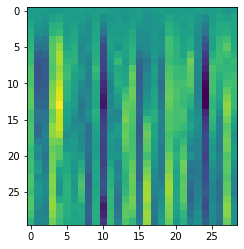

In [22]:
plt.imshow(generated_image_a[ :, :])

In [23]:
noise.shape

TensorShape([6591, 30, 29])

In [24]:
def make_discriminator_model():
    model = tf.keras.Sequential()
#     model.add(layers.GRU(32, input_length=height, input_dim=width, return_sequences=True))
#     model.add(layers.Dropout(0.3))
    model.add(layers.LSTM(32, input_length=height, input_dim=width, return_sequences=True))
#     model.add(layers.Dropout(0.3))
    model.add(layers.LSTM(16, input_length=height, input_dim=width, return_sequences=False))
#     model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1))
    return model

In [25]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 32)            7936      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 11,089
Trainable params: 11,089
Non-trainable params: 0
_________________________________________________________________


In [26]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor(
[[-0.07905021]
 [ 0.05103326]
 [-0.01810568]
 ...
 [ 0.10785645]
 [-0.04253149]
 [-0.07203434]], shape=(6591, 1), dtype=float32)


In [27]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [29]:
def generator_loss(fake_output):
    generator_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return generator_loss

In [30]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [32]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16 # For visualization

# We will reuse this noise_vector overtime (so it's easier)
# to visualize progress in the animated GIF)
noise_vector = tf.random.normal([num_examples_to_generate,height, width])

In [33]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(16):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :])
      plt.axis('off')

  plt.savefig('./LSTM_picture/plot/image_at_'+str(epoch)+'_'+owner+'.png')
  plt.show()

In [34]:
def accuracy(score):
    acc = accuracy_score(labelD_test, score)
    return acc

In [35]:
def plot_acc(acc):
    arrange=np.arange(0, len(acc), 1, dtype=np.int32)
    plt.figure(figsize=(14,5),dpi=100,linewidth = 4)
    plt.plot(arrange,acc,'b', c='red',label = "acc")
    plt.xlabel("Time(s)", fontsize=10, labelpad = 15)
    plt.ylabel("fuel comsumption", fontsize=10, labelpad = 20)
    plt.legend(loc = "best", fontsize=10)
    plt.savefig('./LSTM_picture/plot/image_at_acc_'+owner+'.png')
    plt.show()

In [36]:
# def evaluate():    
#     score = np.empty([labelD_test.shape[0]])
#     for i in range(len(dataD_test)):
#         a=0
#         test = np.reshape(dataD_test[i],[1,dataD_test[i].shape[0],dataD_test[i].shape[1]])
#         d=discriminator(test)
#         if float(d) > 0:
#             a=0
#         else:
#             a=1
#         score[i]=a
#     return score
def evaluate():    
    score = np.empty([labelD_test.shape[0]])
    for i in range(len(dataD_test)):
        noise = tf.random.normal([1, height, width])
        test = np.reshape(dataD_test[i],[1,dataD_test[i].shape[0],dataD_test[i].shape[1]])
        test_a = np.reshape(test,[height,width])
        generated_image=generator(noise, training=False)
        generated_image_a = np.reshape(generated_image,[height,width])
        a=mean_squared_error(test_a, generated_image_a)
        score[i]=a
    return score

In [37]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE,height, width])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # Generator output
        generated_images = generator(noise, training=True)
      
      # Discriminator output
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True) 
      
      # Loss functions
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
  
    # Gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Update both networks
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss,disc_loss

In [38]:
def train(dataset, epochs):
      score1 = np.empty([labelD_test.shape[0]])
      gen_loss =np.empty([EPOCHS])
      disc_loss =np.empty([EPOCHS])
      acc = np.zeros([int(EPOCHS/epoch_dura)])
    
      for epoch in range(epochs):
        start = time.time()
        if epoch%epoch_dura ==0:
            score = evaluate()
            score1 = np.vstack((score1,score))
#             acc[int(epoch/epoch_dura)] = accuracy(score)
#             plot_acc(acc)
#             print(acc)

        for image_batch in dataset:
            gen_loss[epoch],disc_loss[epoch]=train_step(image_batch)


        # Produce images for the GIF as we go
#         display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 noise_vector)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

      # Generate after the final epoch
#         display.clear_output(wait=True)
        generate_and_save_images(generator,
                               epochs,
                               noise_vector)
      np.save("./LSTMGAN_score/score_owner"+owner+".npy", score1)
      np.save("./LSTMGAN_loss/gloss_owner"+owner+".npy", gen_loss)
      np.save("./LSTMGAN_loss/dloss_owner"+owner+".npy", disc_loss)

In [39]:
# BUFFER_SIZE = 60000
BATCH_SIZE = 32
dataD_train=dataD_train.astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(dataD_train).shuffle(dataD_train.shape[0]).batch(BATCH_SIZE)

In [40]:
dataD_train.shape

(6591, 30, 29)

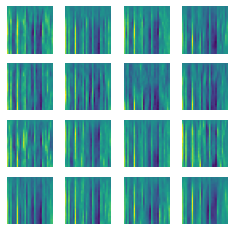

Time for epoch 1 is 227.37349247932434 sec


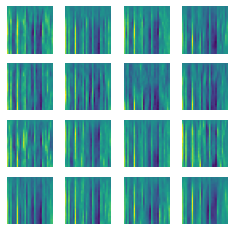

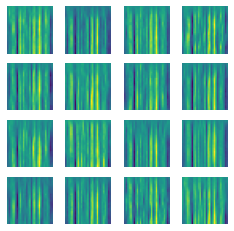

Time for epoch 2 is 46.28692293167114 sec


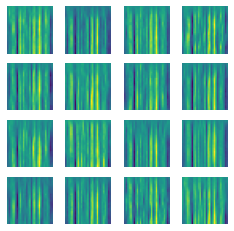

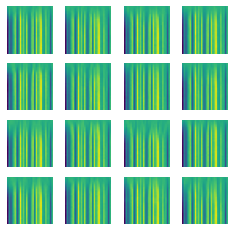

Time for epoch 3 is 46.246232986450195 sec


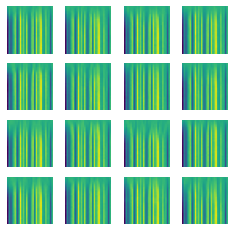

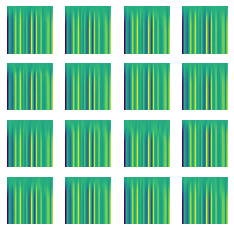

Time for epoch 4 is 45.83438205718994 sec


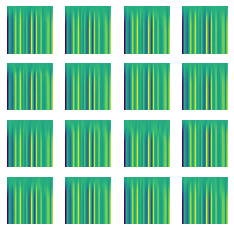

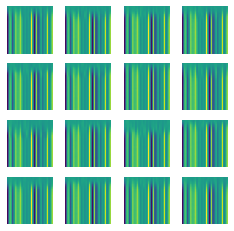

Time for epoch 5 is 46.011239767074585 sec


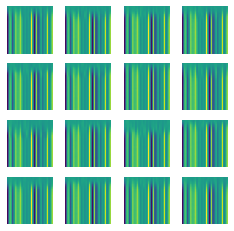

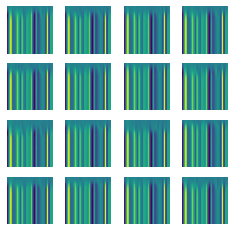

Time for epoch 6 is 218.7281973361969 sec


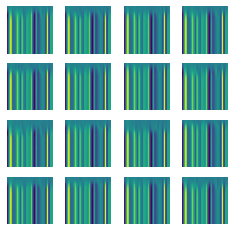

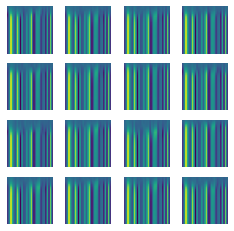

Time for epoch 7 is 45.86511278152466 sec


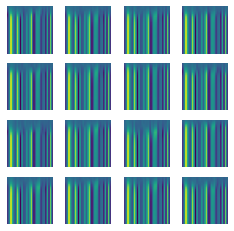

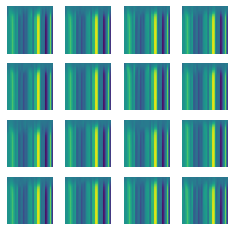

Time for epoch 8 is 46.34895443916321 sec


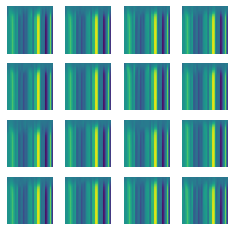

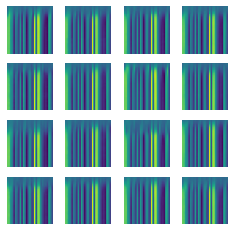

Time for epoch 9 is 45.73702383041382 sec


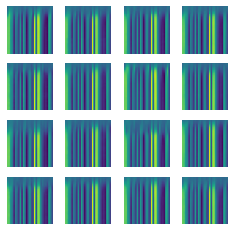

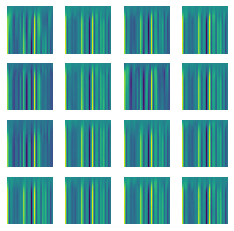

Time for epoch 10 is 45.96293902397156 sec


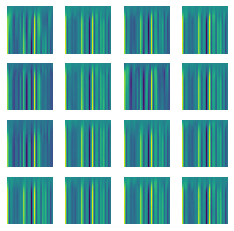

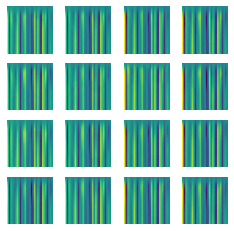

Time for epoch 11 is 219.7393307685852 sec


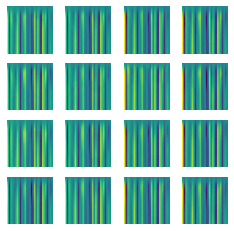

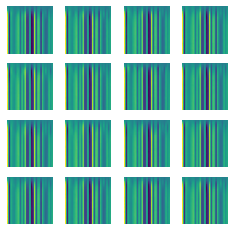

Time for epoch 12 is 46.0496461391449 sec


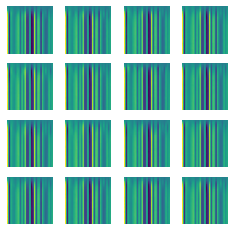

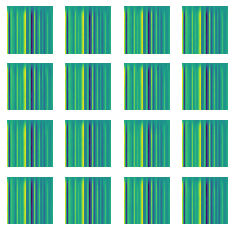

Time for epoch 13 is 46.015214681625366 sec


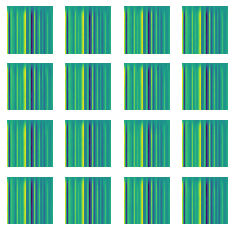

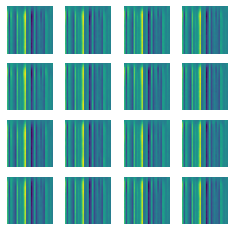

Time for epoch 14 is 46.190600872039795 sec


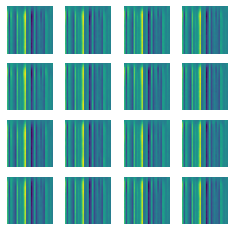

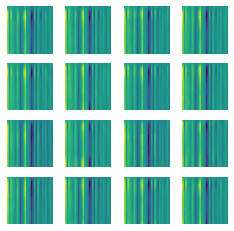

Time for epoch 15 is 46.24302434921265 sec


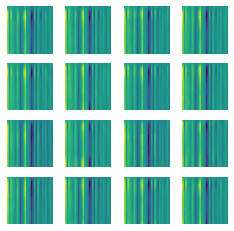

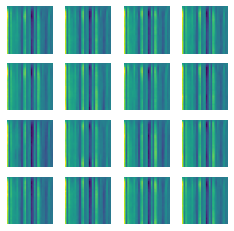

Time for epoch 16 is 220.70374846458435 sec


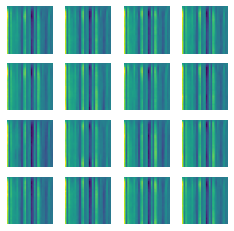

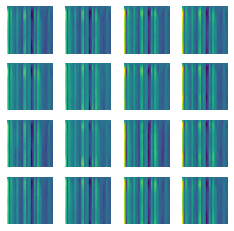

Time for epoch 17 is 46.194262742996216 sec


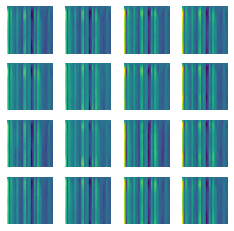

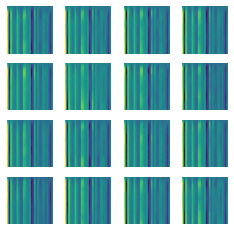

Time for epoch 18 is 46.33854031562805 sec


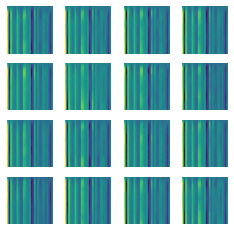

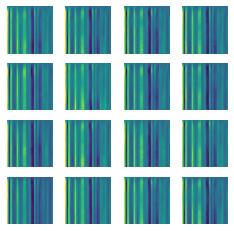

Time for epoch 19 is 46.11361837387085 sec


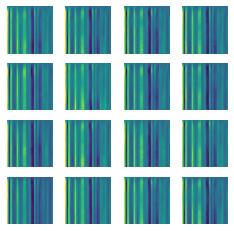

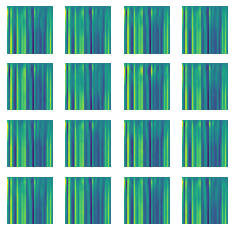

Time for epoch 20 is 46.17690420150757 sec


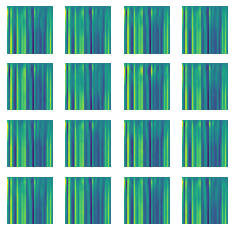

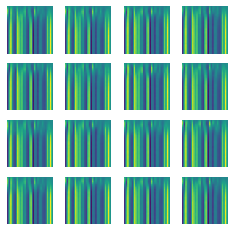

Time for epoch 21 is 222.0375680923462 sec


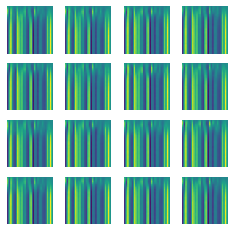

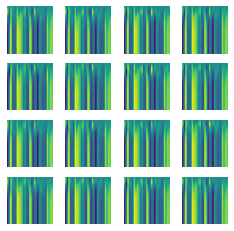

Time for epoch 22 is 46.141544342041016 sec


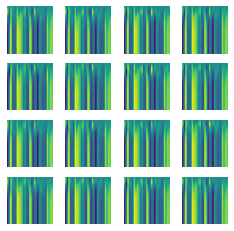

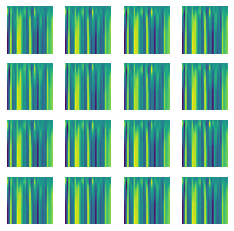

Time for epoch 23 is 46.1361563205719 sec


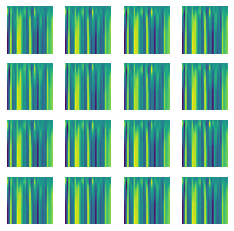

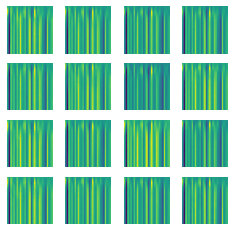

Time for epoch 24 is 45.93473529815674 sec


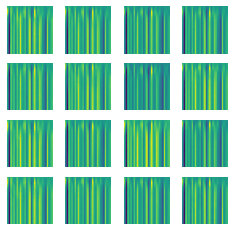

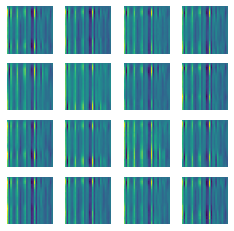

Time for epoch 25 is 46.19300818443298 sec


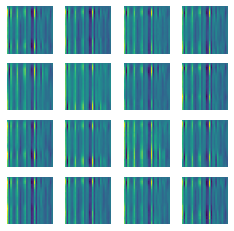

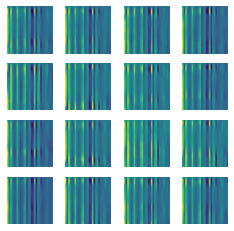

Time for epoch 26 is 219.4741086959839 sec


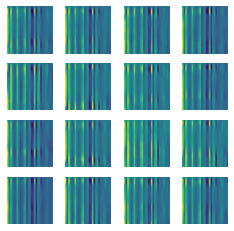

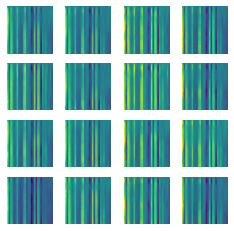

Time for epoch 27 is 46.22183275222778 sec


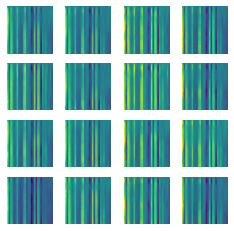

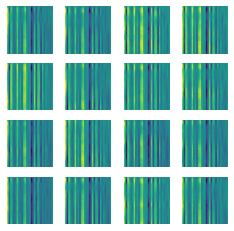

Time for epoch 28 is 46.01163864135742 sec


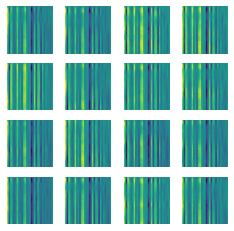

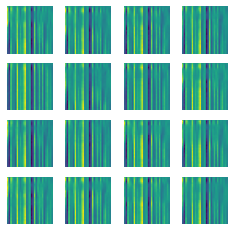

Time for epoch 29 is 46.243308782577515 sec


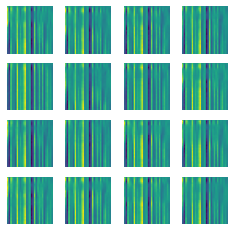

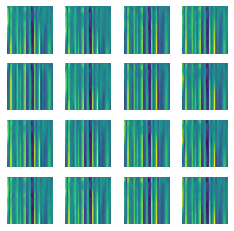

Time for epoch 30 is 46.24029803276062 sec


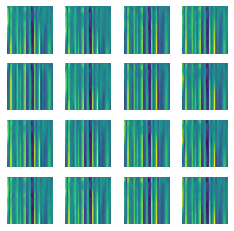

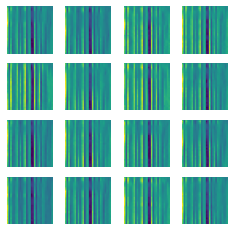

Time for epoch 31 is 219.24568605422974 sec


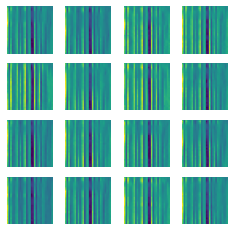

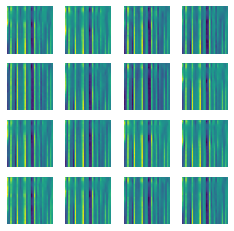

Time for epoch 32 is 46.173768758773804 sec


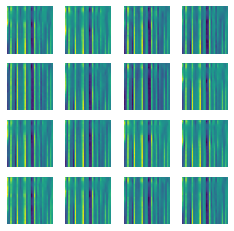

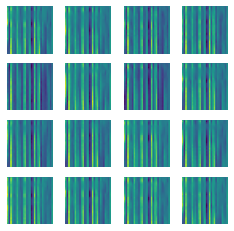

Time for epoch 33 is 46.26267862319946 sec


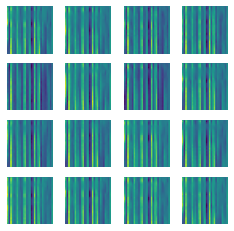

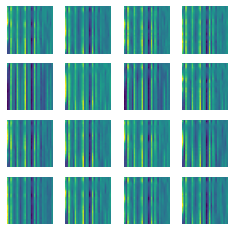

Time for epoch 34 is 46.30252265930176 sec


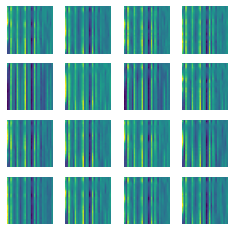

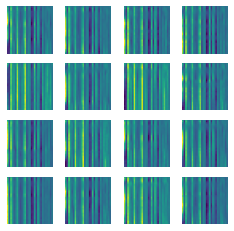

Time for epoch 35 is 46.1590142250061 sec


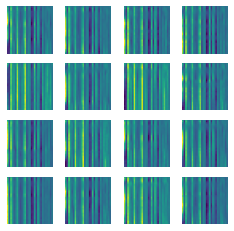

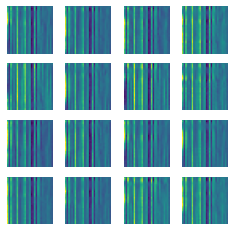

Time for epoch 36 is 221.12181758880615 sec


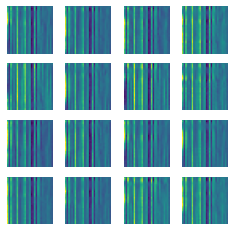

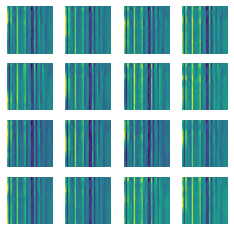

Time for epoch 37 is 46.16713237762451 sec


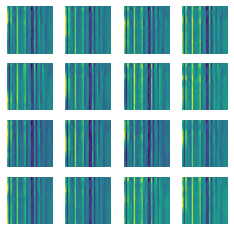

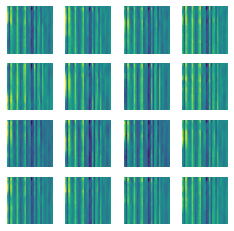

Time for epoch 38 is 46.38008975982666 sec


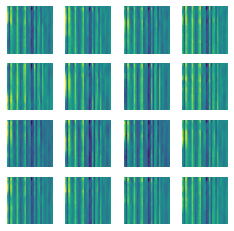

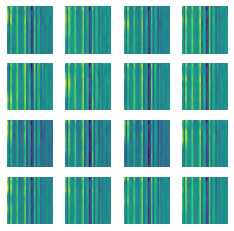

Time for epoch 39 is 46.12569332122803 sec


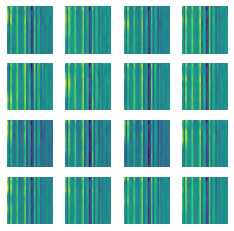

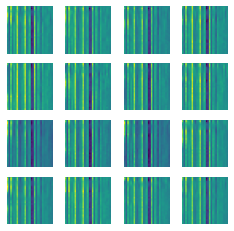

Time for epoch 40 is 46.44359230995178 sec


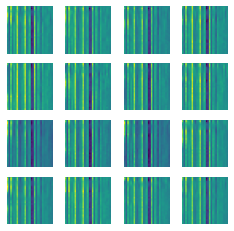

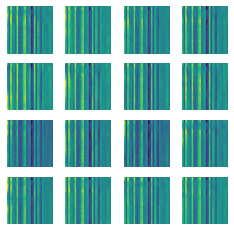

Time for epoch 41 is 219.8114366531372 sec


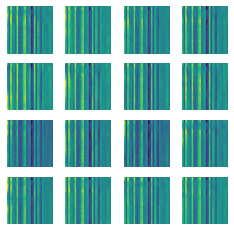

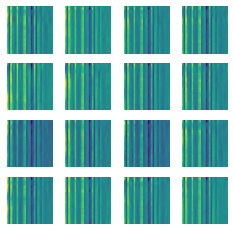

Time for epoch 42 is 46.16795086860657 sec


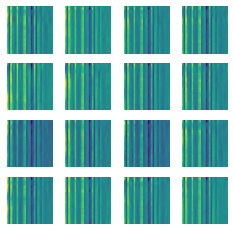

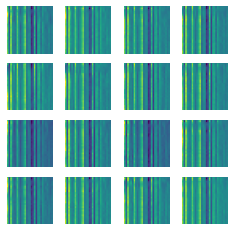

Time for epoch 43 is 45.92376685142517 sec


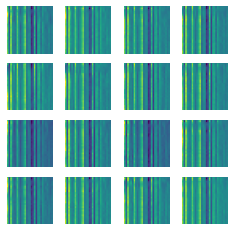

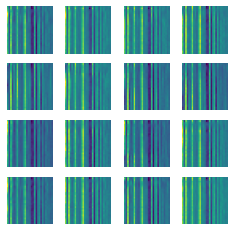

Time for epoch 44 is 46.226027965545654 sec


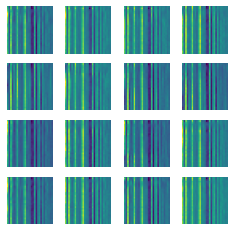

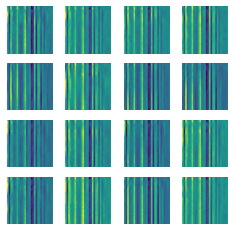

Time for epoch 45 is 46.06497573852539 sec


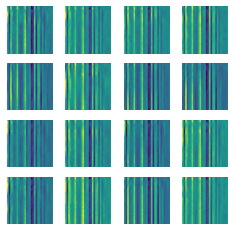

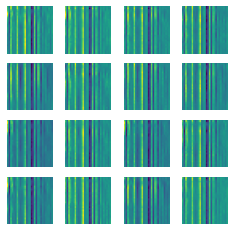

Time for epoch 46 is 218.65064096450806 sec


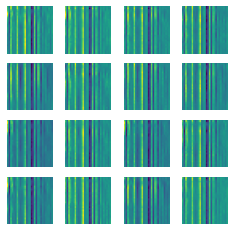

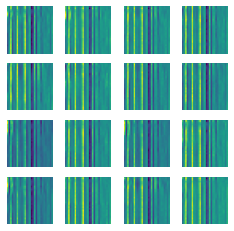

Time for epoch 47 is 46.37911558151245 sec


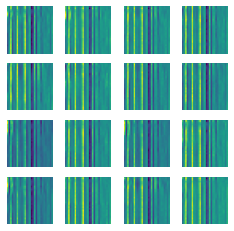

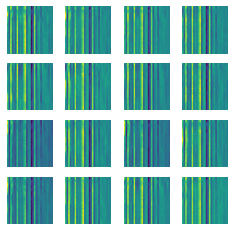

Time for epoch 48 is 46.00541639328003 sec


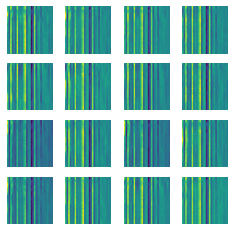

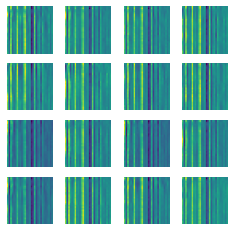

Time for epoch 49 is 46.05337834358215 sec


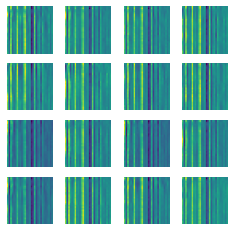

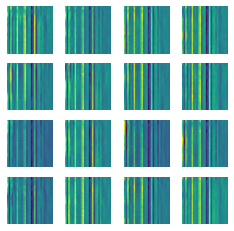

Time for epoch 50 is 46.226417541503906 sec


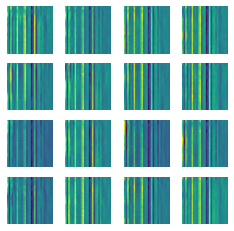

Wall time: 1h 7min 51s


In [41]:
%%time
train(train_dataset, EPOCHS)

In [42]:
# owner='A'

In [43]:
score1=np.load('./LSTMGAN_score/score_owner'+owner+'.npy',allow_pickle=True)
labelD_test=np.load('./LSTMGAN_score/label_owner'+owner+'.npy',allow_pickle=True)
gen_loss=np.load('./LSTMGAN_loss/gloss_owner'+owner+'.npy', allow_pickle=True)
disc_loss=np.load('./LSTMGAN_loss/dloss_owner'+owner+'.npy', allow_pickle=True)

In [54]:
D_L = np.empty([score1.shape[1]])
precision = np.empty([score1.shape[0]-1])
recall = np.empty([score1.shape[0]-1])
f1 = np.empty([score1.shape[0]-1])
acc = np.empty([score1.shape[0]-1])
for j in range (score1.shape[0]-1):
    for i in range(score1.shape[1]):
        if score1[j+1][i]>0.2:
            # true/negative
            D_L[i] = 1
        else:
            # false/positive
            D_L[i] = 0
    precision[j], recall[j], f1[j], _ = precision_recall_fscore_support(labelD_test, D_L, average='binary')
    acc[j] = accuracy_score(labelD_test, D_L)

In [45]:
# precision = np.empty([score1.shape[0]-1])
# recall = np.empty([score1.shape[0]-1])
# f1 = np.empty([score1.shape[0]-1])
# acc = np.empty([score1.shape[0]-1])
# for i in range (score1.shape[0]-1):
#     precision[i], recall[i], f1[i], _ = precision_recall_fscore_support(labelD_test, score1[i+1],pos_label=1, average='binary')
#     acc[i] = accuracy_score(labelD_test, score1[i+1])

In [46]:
# a=0
# for i in range (len(score1[5])):
#     if score1[5][i]+labelD_test[i]==0:
#         a=a+1

In [47]:
# a

In [56]:
a=0
b=0
c=6
for i in range (len(score1[c])):
    if score1[c][i]<=0.2:
        a = a + score1[c][i]
        b=b+1
a=a/b
a

0.093280567347251

In [55]:
acc

array([0.44885184, 0.80716689, 0.80716689, 0.87465263, 0.89167764,
       0.99719175, 0.94687729, 0.97893813, 0.96682756, 0.93251426])

In [50]:
precision

array([0.80552752, 0.80716689, 0.80716689, 0.90787352, 0.80721411,
       0.93059256, 0.81941557, 0.92090245, 0.92167145, 0.92566004])

In [51]:
recall

array([0.98340159, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [52]:
f1

array([0.8856215 , 0.89329535, 0.89329535, 0.95171248, 0.89332427,
       0.96404863, 0.90074592, 0.95882271, 0.95923937, 0.96139507])

ValueError: x and y must have same first dimension, but have shapes (20,) and (10,)

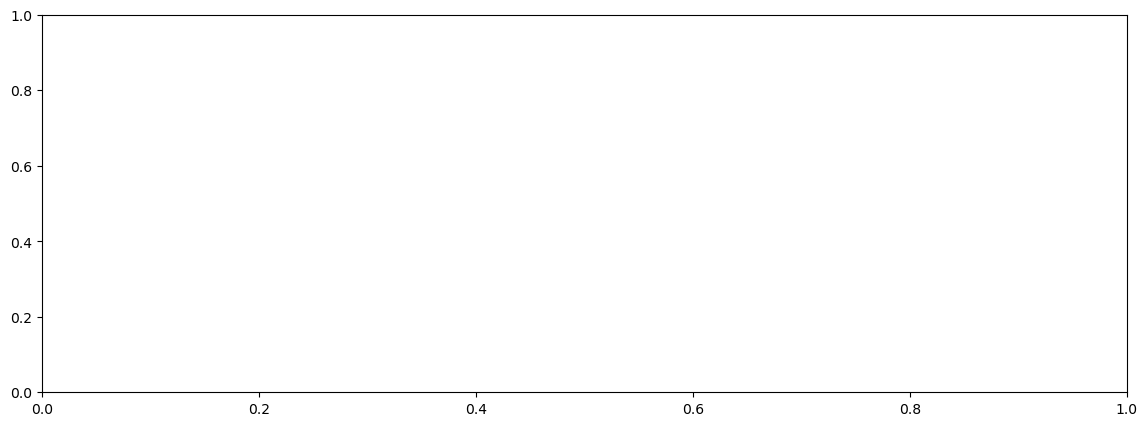

In [53]:
arrange=np.arange(0, 20, 1, dtype=np.int32)
plt.figure(figsize=(14,5),dpi=100,linewidth = 4)
plt.plot(arrange,acc,'b', c='red',label = "acc")
plt.plot(arrange,precision,'b', c='blue',label = "precision")
plt.plot(arrange,recall,'b', c='pink',label = "recall")
plt.plot(arrange,f1,'b', c='green',label = "f1")
# plt.plot(arrange1,gen_loss,'b', c='green',label = "g_loss")
# plt.plot(arrange1,disc_loss, 'b',c='pink',label = "d_loss")
plt.xlabel("Time(s)", fontsize=10, labelpad = 15)
plt.ylabel("fuel comsumption", fontsize=10, labelpad = 20)
plt.legend(loc = "best", fontsize=10)
# plt.savefig("./picture/driverA&D_fuel comsumption.png")

In [ ]:
arrange1=np.arange(0, 100, 1, dtype=np.int32)
plt.figure(figsize=(14,5),dpi=100,linewidth = 4)
plt.plot(arrange1,gen_loss,'b', c='green',label = "g_loss")
plt.plot(arrange1,disc_loss, 'b',c='pink',label = "d_loss")
plt.xlabel("Time(s)", fontsize=10, labelpad = 15)
plt.ylabel("fuel comsumption", fontsize=10, labelpad = 20)
plt.legend(loc = "best", fontsize=10)